##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Uncertainty-aware Deep Learning with SNGP

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/understanding/sngp"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/understanding/sngp.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/understanding/sngp.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/understanding/sngp.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In AI applications that are safety-critical, such as medical decision making and autonomous driving, or where the data is inherently noisy (for example, natural language understanding), it is important for a deep classifier to reliably quantify its uncertainty. The deep classifier should be able to be aware of its own limitations and when it should hand control over to the human experts. This tutorial shows how to improve a deep classifier's ability in quantifying uncertainty using a technique called **Spectral-normalized Neural Gaussian Process ([SNGP](https://arxiv.org/abs/2006.10108){.external})**.

The core idea of SNGP is to improve a deep classifier's _**distance awareness**_ by applying simple modifications to the network. A model's _distance awareness_ is a measure of how its predictive probability reflects the distance between the test example and the training data. This is a desirable property that is common for gold-standard probabilistic models (for example, the [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process){.external} with RBF kernels) but is lacking in models with deep neural networks. SNGP provides a simple way to inject this Gaussian-process behavior into a deep classifier while maintaining its predictive accuracy.

This tutorial implements a deep residual network (ResNet)-based SNGP model on [scikit-learn’s two moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html){.external} dataset, and compares its uncertainty surface with that of two other popular uncertainty approaches: [Monte Carlo dropout](https://arxiv.org/abs/1506.02142){.external} and [Deep ensemble](https://arxiv.org/abs/1612.01474){.external}.

This tutorial illustrates the SNGP model on a toy 2D dataset. For an example of applying SNGP to a real-world natural language understanding task using a BERT-base, check out the [SNGP-BERT tutorial](https://www.tensorflow.org/text/tutorials/uncertainty_quantification_with_sngp_bert). For high-quality implementations of an SNGP model (and many other uncertainty methods) on a wide variety of benchmark datasets (such as [CIFAR-100](https://www.tensorflow.org/datasets/catalog/cifar100), [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012), [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), etc), refer to the [Uncertainty Baselines](https://github.com/google/uncertainty-baselines){.external} benchmark.

## About SNGP

SNGP is a simple approach to improve a deep classifier's uncertainty quality while maintaining a similar level of accuracy and latency. Given a deep residual network, SNGP makes two simple changes to the model:

* It applies spectral normalization to the hidden residual layers.
* It replaces the Dense output layer with a Gaussian process layer.

>![SNGP](http://tensorflow.org/tutorials/understanding/images/sngp.png)


Compared to other uncertainty approaches (such as Monte Carlo dropout or Deep ensemble), SNGP has several advantages:

* It works for a wide range of state-of-the-art residual-based architectures (for example, (Wide) ResNet, DenseNet, or BERT).
* It is a single-model method—it does not rely on ensemble averaging). Therefore, SNGP has a similar level of latency as a single deterministic network, and can be scaled easily to large datasets like [ImageNet](https://github.com/google/uncertainty-baselines/tree/main/baselines/imagenet){.external} and [Jigsaw Toxic Comments classification](https://github.com/google/uncertainty-baselines/tree/main/baselines/toxic_comments){.external}.
* It has strong out-of-domain detection performance due to the _distance-awareness_ property.

The downsides of this method are:

* The predictive uncertainty of SNGP is computed using the [Laplace approximation](http://www.gaussianprocess.org/gpml/chapters/RW3.pdf){.external}. Therefore, theoretically, the posterior uncertainty of SNGP is different from that of an exact Gaussian process.

* SNGP training needs a covariance reset step at the beginning of a new epoch. This can add a tiny amount of extra complexity to a training pipeline. This tutorial shows a simple way to implement this using Keras callbacks.

## Setup

In [2]:
!pip install -U -q --use-deprecated=legacy-resolver tf-models-official tensorflow

In [3]:
# refresh pkg_resources so it takes the changes into account.
import pkg_resources
import importlib
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/pkg_resources/__init__.py'>

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets

import numpy as np
import tensorflow as tf

import official.nlp.modeling.layers as nlp_layers

2022-12-22 02:21:18.545232: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-22 02:21:18.545333: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-22 02:21:18.545343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Define visualization macros

In [5]:
plt.rcParams['figure.dpi'] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

## The two moon dataset

Create the training and evaluation datasets from the [scikit-learn two moon dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html){.external}.

In [6]:
def make_training_data(sample_size=500):
  """Create two moon training dataset."""
  train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

  # Adjust data position slightly.
  train_examples[train_labels == 0] += [-0.1, 0.2]
  train_examples[train_labels == 1] += [0.1, -0.2]

  return train_examples, train_labels

Evaluate the model's predictive behavior over the entire 2D input space.

In [7]:
def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
  """Create a mesh grid in 2D space."""
  # testing data (mesh grid over data space)
  x = np.linspace(x_range[0], x_range[1], n_grid)
  y = np.linspace(y_range[0], y_range[1], n_grid)
  xv, yv = np.meshgrid(x, y)
  return np.stack([xv.flatten(), yv.flatten()], axis=-1)

To evaluate model uncertainty, add an out-of-domain (OOD) dataset that belongs to a third class. The model never observes these OOD examples during training.

In [8]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
  return np.random.multivariate_normal(
      means, cov=np.diag(vars), size=sample_size)

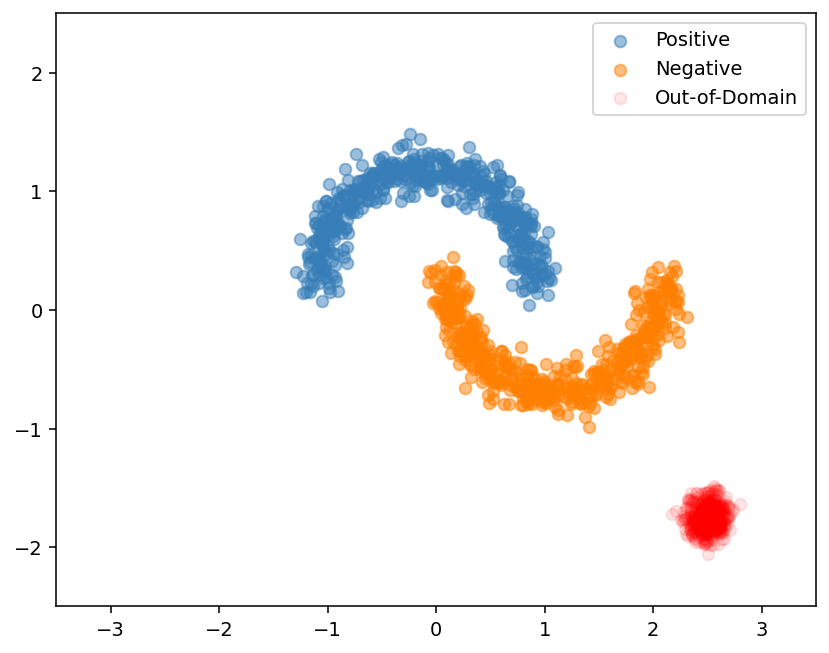

In [9]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(
    sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Positive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

Here, the blue and orange represent the positive and negative classes, and the red represents the OOD data. A model that quantifies the uncertainty well is expected to be confident when close to training data  (i.e., $p(x_{test})$ close to 0 or 1), and be uncertain when far away from the training data regions  (i.e., $p(x_{test})$ close to 0.5).

## The deterministic model

### Define model

Start from the (baseline) deterministic model: a multi-layer residual network (ResNet) with dropout regularization.

In [10]:
#@title
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the ResNet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid

    return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

This tutorial uses a six-layer ResNet with 128 hidden units.

In [11]:
resnet_config = dict(num_classes=2, num_layers=6, num_hidden=128)

In [12]:
resnet_model = DeepResNet(**resnet_config)

In [13]:
resnet_model.build((None, 2))
resnet_model.summary()

Model: "deep_res_net"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               multiple                  384       


 dense_1 (Dense)             multiple                  16512     


 dense_2 (Dense)             multiple                  16512     


 dense_3 (Dense)             multiple                  16512     


 dense_4 (Dense)             multiple                  16512     


 dense_5 (Dense)             multiple                  16512     


 dense_6 (Dense)             multiple                  16512     


 dense_7 (Dense)             multiple                  258       


Total params: 99,714


Trainable params: 99,330


Non-trainable params: 384


_________________________________________________________________


### Train model

Configure the training parameters to use `SparseCategoricalCrossentropy` as the loss function and the Adam optimizer.

In [14]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy(),
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

Train the model for 100 epochs with batch size 128.

In [15]:
fit_config = dict(batch_size=128, epochs=100)

In [16]:
resnet_model.compile(**train_config)
resnet_model.fit(train_examples, train_labels, **fit_config)

Epoch 1/100


1/8 [==>...........................] - ETA: 18s - loss: 1.1452 - sparse_categorical_accuracy: 0.4688

8/8 [==============================] - 3s 4ms/step - loss: 0.8822 - sparse_categorical_accuracy: 0.5250


Epoch 2/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5551 - sparse_categorical_accuracy: 0.6641

8/8 [==============================] - 0s 3ms/step - loss: 0.4462 - sparse_categorical_accuracy: 0.8100


Epoch 3/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2670 - sparse_categorical_accuracy: 0.9141

8/8 [==============================] - 0s 3ms/step - loss: 0.3058 - sparse_categorical_accuracy: 0.8810


Epoch 4/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2326 - sparse_categorical_accuracy: 0.9141

8/8 [==============================] - 0s 3ms/step - loss: 0.2326 - sparse_categorical_accuracy: 0.9030


Epoch 5/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1924 - sparse_categorical_accuracy: 0.9219

8/8 [==============================] - 0s 3ms/step - loss: 0.1852 - sparse_categorical_accuracy: 0.9220


Epoch 6/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1487 - sparse_categorical_accuracy: 0.9531

8/8 [==============================] - 0s 3ms/step - loss: 0.1609 - sparse_categorical_accuracy: 0.9370


Epoch 7/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1354 - sparse_categorical_accuracy: 0.9688

8/8 [==============================] - 0s 3ms/step - loss: 0.1424 - sparse_categorical_accuracy: 0.9450


Epoch 8/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1180 - sparse_categorical_accuracy: 0.9531

8/8 [==============================] - 0s 3ms/step - loss: 0.1375 - sparse_categorical_accuracy: 0.9410


Epoch 9/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1768 - sparse_categorical_accuracy: 0.9062

8/8 [==============================] - 0s 3ms/step - loss: 0.1313 - sparse_categorical_accuracy: 0.9400


Epoch 10/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1382 - sparse_categorical_accuracy: 0.9297

8/8 [==============================] - 0s 3ms/step - loss: 0.1287 - sparse_categorical_accuracy: 0.9380


Epoch 11/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1170 - sparse_categorical_accuracy: 0.9375

8/8 [==============================] - 0s 3ms/step - loss: 0.1165 - sparse_categorical_accuracy: 0.9430


Epoch 12/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1002 - sparse_categorical_accuracy: 0.9531

8/8 [==============================] - 0s 3ms/step - loss: 0.1134 - sparse_categorical_accuracy: 0.9450


Epoch 13/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1281 - sparse_categorical_accuracy: 0.9375

8/8 [==============================] - 0s 3ms/step - loss: 0.1104 - sparse_categorical_accuracy: 0.9470


Epoch 14/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1099 - sparse_categorical_accuracy: 0.9453

8/8 [==============================] - 0s 3ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.9440


Epoch 15/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1214 - sparse_categorical_accuracy: 0.9219

8/8 [==============================] - 0s 3ms/step - loss: 0.1014 - sparse_categorical_accuracy: 0.9470


Epoch 16/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1215 - sparse_categorical_accuracy: 0.9375

8/8 [==============================] - 0s 3ms/step - loss: 0.0988 - sparse_categorical_accuracy: 0.9520


Epoch 17/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1024 - sparse_categorical_accuracy: 0.9453

8/8 [==============================] - 0s 3ms/step - loss: 0.0944 - sparse_categorical_accuracy: 0.9500


Epoch 18/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1019 - sparse_categorical_accuracy: 0.9375

8/8 [==============================] - 0s 3ms/step - loss: 0.0958 - sparse_categorical_accuracy: 0.9520


Epoch 19/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1038 - sparse_categorical_accuracy: 0.9375

8/8 [==============================] - 0s 3ms/step - loss: 0.0920 - sparse_categorical_accuracy: 0.9510


Epoch 20/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0785 - sparse_categorical_accuracy: 0.9609

8/8 [==============================] - 0s 3ms/step - loss: 0.0888 - sparse_categorical_accuracy: 0.9520


Epoch 21/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0990 - sparse_categorical_accuracy: 0.9453

8/8 [==============================] - 0s 3ms/step - loss: 0.0859 - sparse_categorical_accuracy: 0.9590


Epoch 22/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0705 - sparse_categorical_accuracy: 0.9688

8/8 [==============================] - 0s 3ms/step - loss: 0.0861 - sparse_categorical_accuracy: 0.9500


Epoch 23/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1229 - sparse_categorical_accuracy: 0.9375

8/8 [==============================] - 0s 3ms/step - loss: 0.0822 - sparse_categorical_accuracy: 0.9580


Epoch 24/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0696 - sparse_categorical_accuracy: 0.9688

8/8 [==============================] - 0s 3ms/step - loss: 0.0799 - sparse_categorical_accuracy: 0.9580


Epoch 25/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0717 - sparse_categorical_accuracy: 0.9688

8/8 [==============================] - 0s 3ms/step - loss: 0.0769 - sparse_categorical_accuracy: 0.9600


Epoch 26/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0658 - sparse_categorical_accuracy: 0.9688

8/8 [==============================] - 0s 3ms/step - loss: 0.0816 - sparse_categorical_accuracy: 0.9580


Epoch 27/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0490 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0747 - sparse_categorical_accuracy: 0.9630


Epoch 28/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0877 - sparse_categorical_accuracy: 0.9375

8/8 [==============================] - 0s 3ms/step - loss: 0.0713 - sparse_categorical_accuracy: 0.9610


Epoch 29/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0977 - sparse_categorical_accuracy: 0.9453

8/8 [==============================] - 0s 3ms/step - loss: 0.0803 - sparse_categorical_accuracy: 0.9580


Epoch 30/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0651 - sparse_categorical_accuracy: 0.9688

8/8 [==============================] - 0s 3ms/step - loss: 0.0757 - sparse_categorical_accuracy: 0.9590


Epoch 31/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0937 - sparse_categorical_accuracy: 0.9453

8/8 [==============================] - 0s 3ms/step - loss: 0.0734 - sparse_categorical_accuracy: 0.9580


Epoch 32/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0873 - sparse_categorical_accuracy: 0.9375

8/8 [==============================] - 0s 3ms/step - loss: 0.0734 - sparse_categorical_accuracy: 0.9620


Epoch 33/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0985 - sparse_categorical_accuracy: 0.9453

8/8 [==============================] - 0s 3ms/step - loss: 0.0730 - sparse_categorical_accuracy: 0.9640


Epoch 34/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0671 - sparse_categorical_accuracy: 0.9531

8/8 [==============================] - 0s 3ms/step - loss: 0.0698 - sparse_categorical_accuracy: 0.9630


Epoch 35/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0566 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0672 - sparse_categorical_accuracy: 0.9700


Epoch 36/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0813 - sparse_categorical_accuracy: 0.9766

8/8 [==============================] - 0s 3ms/step - loss: 0.0652 - sparse_categorical_accuracy: 0.9710


Epoch 37/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0617 - sparse_categorical_accuracy: 0.9688

8/8 [==============================] - 0s 3ms/step - loss: 0.0616 - sparse_categorical_accuracy: 0.9750


Epoch 38/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0636 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0641 - sparse_categorical_accuracy: 0.9740


Epoch 39/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0429 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0623 - sparse_categorical_accuracy: 0.9700


Epoch 40/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0783 - sparse_categorical_accuracy: 0.9688

8/8 [==============================] - 0s 3ms/step - loss: 0.0648 - sparse_categorical_accuracy: 0.9720


Epoch 41/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0560 - sparse_categorical_accuracy: 0.9766

8/8 [==============================] - 0s 3ms/step - loss: 0.0563 - sparse_categorical_accuracy: 0.9780


Epoch 42/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0561 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0587 - sparse_categorical_accuracy: 0.9740


Epoch 43/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0527 - sparse_categorical_accuracy: 0.9766

8/8 [==============================] - 0s 3ms/step - loss: 0.0575 - sparse_categorical_accuracy: 0.9780


Epoch 44/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0563 - sparse_categorical_accuracy: 0.9688

8/8 [==============================] - 0s 3ms/step - loss: 0.0564 - sparse_categorical_accuracy: 0.9740


Epoch 45/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0650 - sparse_categorical_accuracy: 0.9609

8/8 [==============================] - 0s 3ms/step - loss: 0.0599 - sparse_categorical_accuracy: 0.9720


Epoch 46/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0237 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0569 - sparse_categorical_accuracy: 0.9780


Epoch 47/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0395 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0519 - sparse_categorical_accuracy: 0.9810


Epoch 48/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0627 - sparse_categorical_accuracy: 0.9609

8/8 [==============================] - 0s 3ms/step - loss: 0.0530 - sparse_categorical_accuracy: 0.9780


Epoch 49/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0457 - sparse_categorical_accuracy: 0.9766

8/8 [==============================] - 0s 3ms/step - loss: 0.0512 - sparse_categorical_accuracy: 0.9800


Epoch 50/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0410 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0503 - sparse_categorical_accuracy: 0.9830


Epoch 51/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0240 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0465 - sparse_categorical_accuracy: 0.9810


Epoch 52/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0382 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0494 - sparse_categorical_accuracy: 0.9830


Epoch 53/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0712 - sparse_categorical_accuracy: 0.9609

8/8 [==============================] - 0s 3ms/step - loss: 0.0419 - sparse_categorical_accuracy: 0.9890


Epoch 54/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0211 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9850


Epoch 55/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0351 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0463 - sparse_categorical_accuracy: 0.9820


Epoch 56/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0839 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0408 - sparse_categorical_accuracy: 0.9870


Epoch 57/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0356 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0399 - sparse_categorical_accuracy: 0.9870


Epoch 58/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0613 - sparse_categorical_accuracy: 0.9766

8/8 [==============================] - 0s 3ms/step - loss: 0.0388 - sparse_categorical_accuracy: 0.9880


Epoch 59/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0327 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0532 - sparse_categorical_accuracy: 0.9830


Epoch 60/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0617 - sparse_categorical_accuracy: 0.9688

8/8 [==============================] - 0s 3ms/step - loss: 0.0383 - sparse_categorical_accuracy: 0.9890


Epoch 61/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0499 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0388 - sparse_categorical_accuracy: 0.9890


Epoch 62/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0388 - sparse_categorical_accuracy: 0.9766

8/8 [==============================] - 0s 3ms/step - loss: 0.0443 - sparse_categorical_accuracy: 0.9850


Epoch 63/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0444 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0349 - sparse_categorical_accuracy: 0.9880


Epoch 64/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0362 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0332 - sparse_categorical_accuracy: 0.9910


Epoch 65/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0363 - sparse_categorical_accuracy: 0.9880


Epoch 66/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0375 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0332 - sparse_categorical_accuracy: 0.9900


Epoch 67/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0521 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0388 - sparse_categorical_accuracy: 0.9850


Epoch 68/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0361 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0333 - sparse_categorical_accuracy: 0.9920


Epoch 69/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0303 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0323 - sparse_categorical_accuracy: 0.9910


Epoch 70/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0169 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0390 - sparse_categorical_accuracy: 0.9920


Epoch 71/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0085 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0313 - sparse_categorical_accuracy: 0.9920


Epoch 72/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0180 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0332 - sparse_categorical_accuracy: 0.9890


Epoch 73/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0540 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0259 - sparse_categorical_accuracy: 0.9930


Epoch 74/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0314 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0289 - sparse_categorical_accuracy: 0.9890


Epoch 75/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0183 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0269 - sparse_categorical_accuracy: 0.9910


Epoch 76/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0197 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0271 - sparse_categorical_accuracy: 0.9930


Epoch 77/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0071 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0329 - sparse_categorical_accuracy: 0.9900


Epoch 78/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0524 - sparse_categorical_accuracy: 0.9766

8/8 [==============================] - 0s 3ms/step - loss: 0.0276 - sparse_categorical_accuracy: 0.9920


Epoch 79/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0296 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0263 - sparse_categorical_accuracy: 0.9930


Epoch 80/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0189 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0235 - sparse_categorical_accuracy: 0.9920


Epoch 81/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0148 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0245 - sparse_categorical_accuracy: 0.9910


Epoch 82/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0112 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0271 - sparse_categorical_accuracy: 0.9910


Epoch 83/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0183 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0269 - sparse_categorical_accuracy: 0.9950


Epoch 84/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0081 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0296 - sparse_categorical_accuracy: 0.9910


Epoch 85/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0118 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0226 - sparse_categorical_accuracy: 0.9910


Epoch 86/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0157 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0209 - sparse_categorical_accuracy: 0.9940


Epoch 87/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0555 - sparse_categorical_accuracy: 0.9766

8/8 [==============================] - 0s 3ms/step - loss: 0.0228 - sparse_categorical_accuracy: 0.9940


Epoch 88/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0081 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0214 - sparse_categorical_accuracy: 0.9940


Epoch 89/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0143 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0216 - sparse_categorical_accuracy: 0.9930


Epoch 90/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0133 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0230 - sparse_categorical_accuracy: 0.9920


Epoch 91/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0048 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0177 - sparse_categorical_accuracy: 0.9950


Epoch 92/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0530 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9940


Epoch 93/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0218 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0220 - sparse_categorical_accuracy: 0.9920


Epoch 94/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0484 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0170 - sparse_categorical_accuracy: 0.9960


Epoch 95/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0339 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0219 - sparse_categorical_accuracy: 0.9910


Epoch 96/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0140 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0231 - sparse_categorical_accuracy: 0.9930


Epoch 97/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0297 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0212 - sparse_categorical_accuracy: 0.9940


Epoch 98/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0112 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0157 - sparse_categorical_accuracy: 0.9970


Epoch 99/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0205 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0206 - sparse_categorical_accuracy: 0.9930


Epoch 100/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0104 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0179 - sparse_categorical_accuracy: 0.9950


### Visualize uncertainty

In [17]:
#@title
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
  """Visualizes the 2D uncertainty surface.
  
  For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).
  
  Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the
      predictive surface.

  Returns:
    pcm: A matplotlib PathCollection object that contains the palette
      information of the uncertainty plot.
  """
  # Normalize uncertainty for better visualization.
  test_uncertainty = test_uncertainty / np.max(test_uncertainty)

  # Set view limits.
  ax.set_ylim(DEFAULT_Y_RANGE)
  ax.set_xlim(DEFAULT_X_RANGE)

  # Plot normalized uncertainty surface.
  pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]),
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic',
      aspect='auto')

  # Plot training data.
  ax.scatter(train_examples[:, 0], train_examples[:, 1],
             c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
  ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

  return pcm

Now visualize the predictions of the deterministic model. First plot the class probability:
$$p(x) = softmax(logit(x))$$

In [18]:
resnet_logits = resnet_model(test_examples)
resnet_probs = tf.nn.softmax(resnet_logits, axis=-1)[:, 0]  # Take the probability for class 0.

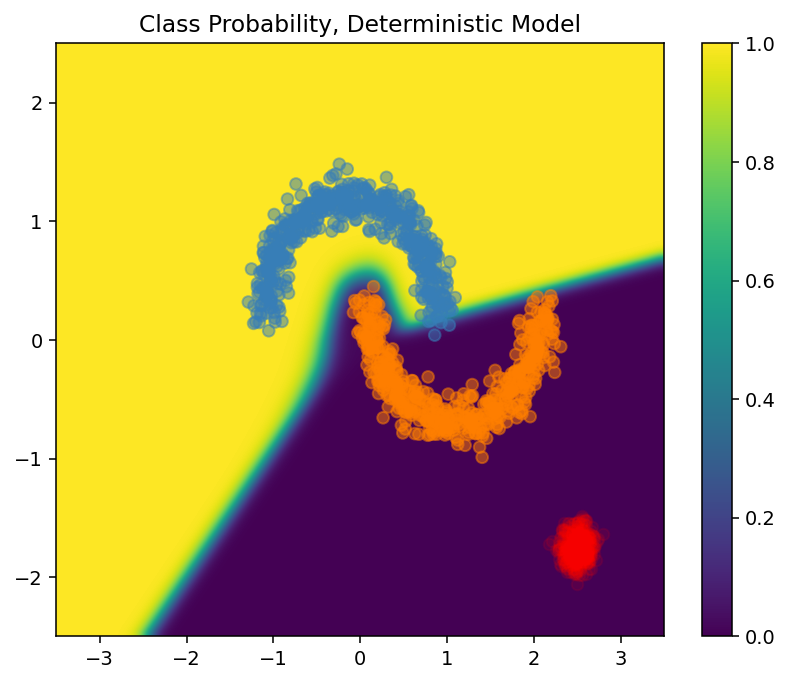

In [19]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_probs, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Class Probability, Deterministic Model")

plt.show()

In this plot, the yellow and purple are the predictive probabilities for the two classes. The deterministic model did a good job in classifying the two known classes—blue and orange—with a nonlinear decision boundary. However, it is not **distance-aware**, and classified the never-observed red out-of-domain (OOD) examples confidently as the orange class.

Visualize the model uncertainty by computing the [predictive variance](https://en.wikipedia.org/wiki/Bernoulli_distribution#Variance):
$$var(x) = p(x) * (1 - p(x))$$

In [20]:
resnet_uncertainty = resnet_probs * (1 - resnet_probs)

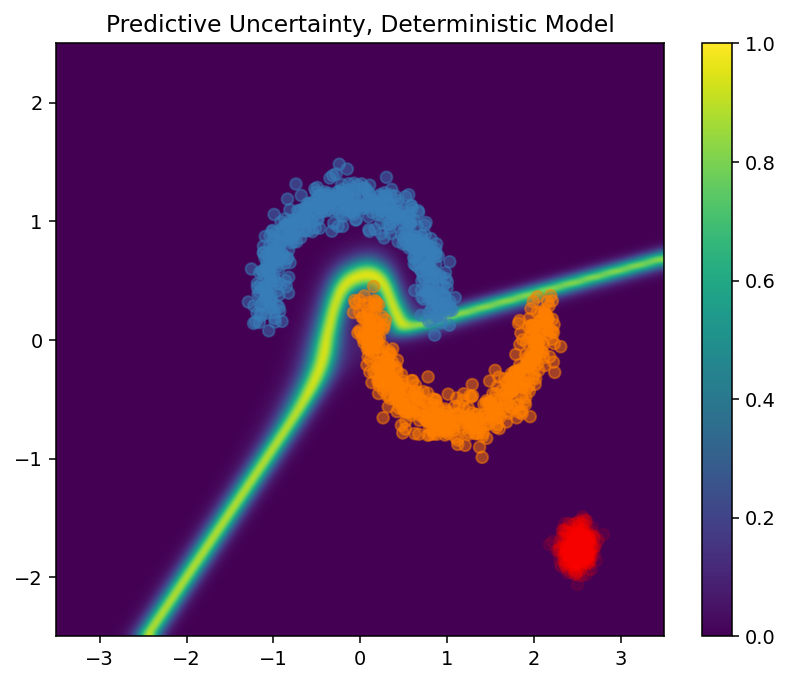

In [21]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_uncertainty, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Predictive Uncertainty, Deterministic Model")

plt.show()

In this plot, the yellow indicates high uncertainty, and the purple indicates low uncertainty. A deterministic ResNet's uncertainty depends only on the test examples' distance from the decision boundary. This leads the model to be over-confident when out of the training domain. The next section shows how SNGP behaves differently on this dataset.

## The SNGP model

### Define SNGP model

Let's now implement the SNGP model. Both the SNGP components, `SpectralNormalization` and `RandomFeatureGaussianProcess`, are available at the tensorflow_model's [built-in  layers](https://github.com/tensorflow/models/tree/master/official/nlp/modeling/layers). 

>![SNGP](http://tensorflow.org/tutorials/understanding/images/sngp.png)


Let's inspect these two components in more detail. (You can also jump to [the full SNGP model](#full-sngp-model) section to learn how SNGP is implemented.)

#### `SpectralNormalization` wrapper

[`SpectralNormalization`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/spectral_normalization.py){.external} is a Keras layer wrapper. It can be applied to an existing Dense layer like this:

In [22]:
dense = tf.keras.layers.Dense(units=10)
dense = nlp_layers.SpectralNormalization(dense, norm_multiplier=0.9)

Spectral normalization regularizes the hidden weight $W$ by gradually guiding its spectral norm (that is, the largest eigenvalue of $W$) toward the target value `norm_multiplier`).


Note: Usually it is preferable to set `norm_multiplier` to a value smaller than 1. However in practice, it can be also relaxed to a larger value to ensure the deep network has enough expressive power.

#### The Gaussian Process (GP) layer

[`RandomFeatureGaussianProcess`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/gaussian_process.py){.external} implements a [random-feature based approximation](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf){.external} to a Gaussian process model that is end-to-end trainable with a deep neural network. Under the hood, the Gaussian process layer implements a two-layer network:

$$logits(x) = \Phi(x) \beta, \quad \Phi(x)=\sqrt{\frac{2}{M}} * cos(Wx + b)$$

Here, $x$ is the input, and $W$ and $b$ are frozen weights initialized randomly from Gaussian and Uniform distributions, respectively. (Therefore, $\Phi(x)$ are called "random features".) $\beta$ is the learnable kernel weight similar to that of a Dense layer. 

In [23]:
batch_size = 32
input_dim = 1024
num_classes = 10

In [24]:
gp_layer = nlp_layers.RandomFeatureGaussianProcess(units=num_classes,
                                               num_inducing=1024,
                                               normalize_input=False,
                                               scale_random_features=True,
                                               gp_cov_momentum=-1)

The main parameters of the GP layers are:

* `units`: The dimension of the output logits.
* `num_inducing`: The dimension $M$ of the hidden weight $W$. Default to 1024.
* `normalize_input`: Whether to apply layer normalization to the input $x$.
* `scale_random_features`: Whether to apply the scale $\sqrt{2/M}$ to the hidden output.


Note: For a deep neural network that is sensitive to the learning rate (for example, ResNet-50 and ResNet-110), it is generally recommended to set `normalize_input=True` to stabilize training, and set `scale_random_features=False` to avoid the learning rate from being modified in unexpected ways when passing through the GP layer.

* `gp_cov_momentum` controls how the model covariance is computed. If set to a positive value (for example, `0.999`), the covariance matrix is computed using the momentum-based moving average update (similar to batch normalization). If set to `-1`, the covariance matrix is updated without momentum.

Note: The momentum-based update method can be sensitive to batch size. Therefore it is generally recommended to set  `gp_cov_momentum=-1` to compute the covariance exactly. For this to work properly, the covariance matrix estimator needs to be reset at the beginning of a new epoch in order to avoid counting the same data twice. For `RandomFeatureGaussianProcess`, this can be done by calling its `reset_covariance_matrix()`. The next section shows an easy implementation of this using Keras' built-in API.


Given a batch input with shape `(batch_size, input_dim)`, the GP layer returns a `logits` tensor (shape `(batch_size, num_classes)`) for prediction, and also  `covmat` tensor (shape `(batch_size, batch_size)`) which is the posterior covariance matrix of the batch logits.

In [25]:
embedding = tf.random.normal(shape=(batch_size, input_dim))

logits, covmat = gp_layer(embedding)

Note: Notice that under this implementation of the SNGP model, the predictive logits $logit(x_{test})$ for all classes share the same covariance matrix $var(x_{test})$, which describes the distance between $x_{test}$ from the training data.

Theoretically, it is possible to extend the algorithm to compute different variance values for different classes (as introduced in the [original SNGP paper](https://arxiv.org/abs/2006.10108){.external}). However, this is difficult to scale to problems with large output spaces (such as classification with ImageNet or language modeling).

<a name="full-sngp-model"></a>
#### The full SNGP model

Given the base class `DeepResNet`, the SNGP model can be implemented easily by  modifying the residual network's hidden and output layers. For compatibility with Keras `model.fit()` API, also modify the model's `call()` method so it only outputs `logits` during training.

In [26]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and a covariance matrix from the GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits

Use the same architecture as the deterministic model.

In [27]:
resnet_config

{'num_classes': 2, 'num_layers': 6, 'num_hidden': 128}

In [28]:
sngp_model = DeepResNetSNGP(**resnet_config)

In [29]:
sngp_model.build((None, 2))
sngp_model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "deep_res_net_sngp"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_9 (Dense)             multiple                  384       


 spectral_normalization_1 (S  multiple                 16768     


 pectralNormalization)                                           


 spectral_normalization_2 (S  multiple                 16768     


 pectralNormalization)                                           


 spectral_normalization_3 (S  multiple                 16768     


 pectralNormalization)                                           


 spectral_normalization_4 (S  multiple                 16768     


 pectralNormalization)                                           


 spectral_normalization_5 (S  multiple                 16768     


 pectralNormalization)                                           


 spectral_normalization_6 (S  multiple                 16768     


 pectralNormalization)                                           


 random_feature_gaussian_pro  multiple                 1182722   


 cess (RandomFeatureGaussian                                     


 Process)                                                        


Total params: 1,283,714


Trainable params: 101,120


Non-trainable params: 1,182,594


_________________________________________________________________


<a name="covariance-reset-callback"></a>
Implement a Keras callback to reset the covariance matrix at the beginning of a new epoch.

In [30]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

Add this callback to the `DeepResNetSNGP` model class.

In [31]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)

### Train model

Use `tf.keras.model.fit` to train the model.

In [32]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
sngp_model.fit(train_examples, train_labels, **fit_config)

Epoch 1/100


1/8 [==>...........................] - ETA: 11s - loss: 0.7008 - sparse_categorical_accuracy: 0.9264

8/8 [==============================] - 2s 4ms/step - loss: 0.6481 - sparse_categorical_accuracy: 0.8915


Epoch 2/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5809 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.5621 - sparse_categorical_accuracy: 0.9960


Epoch 3/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5283 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.5094 - sparse_categorical_accuracy: 1.0000


Epoch 4/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4791 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.4721 - sparse_categorical_accuracy: 1.0000


Epoch 5/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4479 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.4373 - sparse_categorical_accuracy: 1.0000


Epoch 6/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4158 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.4098 - sparse_categorical_accuracy: 1.0000


Epoch 7/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4031 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.3851 - sparse_categorical_accuracy: 0.9990


Epoch 8/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3725 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.3639 - sparse_categorical_accuracy: 0.9990


Epoch 9/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3622 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.3468 - sparse_categorical_accuracy: 0.9990


Epoch 10/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3363 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.3281 - sparse_categorical_accuracy: 0.9990


Epoch 11/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3129 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.3122 - sparse_categorical_accuracy: 0.9990


Epoch 12/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3135 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.2979 - sparse_categorical_accuracy: 0.9990


Epoch 13/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2905 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.2844 - sparse_categorical_accuracy: 0.9990


Epoch 14/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2766 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.2710 - sparse_categorical_accuracy: 0.9990


Epoch 15/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2745 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.2608 - sparse_categorical_accuracy: 0.9970


Epoch 16/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2527 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.2491 - sparse_categorical_accuracy: 0.9990


Epoch 17/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2446 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.2400 - sparse_categorical_accuracy: 0.9990


Epoch 18/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2326 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.2315 - sparse_categorical_accuracy: 0.9990


Epoch 19/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2294 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.2236 - sparse_categorical_accuracy: 0.9980


Epoch 20/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2129 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.2147 - sparse_categorical_accuracy: 0.9990


Epoch 21/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1961 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.2062 - sparse_categorical_accuracy: 0.9980


Epoch 22/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2048 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.1997 - sparse_categorical_accuracy: 0.9980


Epoch 23/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1975 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1931 - sparse_categorical_accuracy: 0.9990


Epoch 24/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1888 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1887 - sparse_categorical_accuracy: 0.9980


Epoch 25/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1765 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1797 - sparse_categorical_accuracy: 0.9990


Epoch 26/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1806 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1754 - sparse_categorical_accuracy: 0.9980


Epoch 27/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1740 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.1710 - sparse_categorical_accuracy: 0.9980


Epoch 28/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1765 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.9980


Epoch 29/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1608 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1605 - sparse_categorical_accuracy: 0.9980


Epoch 30/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1559 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1565 - sparse_categorical_accuracy: 0.9980


Epoch 31/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1503 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1514 - sparse_categorical_accuracy: 0.9990


Epoch 32/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1454 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.9990


Epoch 33/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1528 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.1438 - sparse_categorical_accuracy: 0.9990


Epoch 34/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1424 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1399 - sparse_categorical_accuracy: 0.9990


Epoch 35/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1438 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1348 - sparse_categorical_accuracy: 0.9990


Epoch 36/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1364 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1323 - sparse_categorical_accuracy: 0.9990


Epoch 37/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1292 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1292 - sparse_categorical_accuracy: 0.9990


Epoch 38/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1225 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.9990


Epoch 39/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1255 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.9990


Epoch 40/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1227 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1203 - sparse_categorical_accuracy: 0.9990


Epoch 41/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1166 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1168 - sparse_categorical_accuracy: 0.9990


Epoch 42/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1141 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1137 - sparse_categorical_accuracy: 0.9990


Epoch 43/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1071 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1118 - sparse_categorical_accuracy: 0.9990


Epoch 44/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1085 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1083 - sparse_categorical_accuracy: 0.9990


Epoch 45/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1079 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.9990


Epoch 46/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1061 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.9980


Epoch 47/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1050 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.9990


Epoch 48/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0965 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0986 - sparse_categorical_accuracy: 0.9990


Epoch 49/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0966 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0968 - sparse_categorical_accuracy: 0.9990


Epoch 50/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0963 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0947 - sparse_categorical_accuracy: 0.9990


Epoch 51/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0983 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.0933 - sparse_categorical_accuracy: 0.9990


Epoch 52/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0938 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.0907 - sparse_categorical_accuracy: 0.9990


Epoch 53/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0930 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.0890 - sparse_categorical_accuracy: 0.9990


Epoch 54/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0864 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0874 - sparse_categorical_accuracy: 0.9990


Epoch 55/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0846 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0854 - sparse_categorical_accuracy: 0.9990


Epoch 56/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0820 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0839 - sparse_categorical_accuracy: 0.9990


Epoch 57/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0835 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.0828 - sparse_categorical_accuracy: 0.9990


Epoch 58/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0845 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0807 - sparse_categorical_accuracy: 0.9990


Epoch 59/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0837 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0792 - sparse_categorical_accuracy: 0.9990


Epoch 60/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0836 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.0773 - sparse_categorical_accuracy: 0.9990


Epoch 61/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0812 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.0761 - sparse_categorical_accuracy: 0.9990


Epoch 62/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0753 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0746 - sparse_categorical_accuracy: 0.9990


Epoch 63/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0832 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.0735 - sparse_categorical_accuracy: 0.9990


Epoch 64/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0787 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.0721 - sparse_categorical_accuracy: 0.9990


Epoch 65/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0705 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0703 - sparse_categorical_accuracy: 0.9990


Epoch 66/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0697 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0685 - sparse_categorical_accuracy: 0.9990


Epoch 67/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0675 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0679 - sparse_categorical_accuracy: 0.9990


Epoch 68/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0638 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0666 - sparse_categorical_accuracy: 1.0000


Epoch 69/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0677 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9990


Epoch 70/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0639 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0653 - sparse_categorical_accuracy: 0.9990


Epoch 71/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0662 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0636 - sparse_categorical_accuracy: 0.9990


Epoch 72/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0601 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0621 - sparse_categorical_accuracy: 1.0000


Epoch 73/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0650 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0612 - sparse_categorical_accuracy: 1.0000


Epoch 74/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0604 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0603 - sparse_categorical_accuracy: 1.0000


Epoch 75/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0580 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0596 - sparse_categorical_accuracy: 0.9990


Epoch 76/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0576 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0584 - sparse_categorical_accuracy: 0.9990


Epoch 77/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0575 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0570 - sparse_categorical_accuracy: 0.9990


Epoch 78/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0566 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0566 - sparse_categorical_accuracy: 1.0000


Epoch 79/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0534 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0547 - sparse_categorical_accuracy: 1.0000


Epoch 80/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0576 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0547 - sparse_categorical_accuracy: 1.0000


Epoch 81/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0549 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0533 - sparse_categorical_accuracy: 1.0000


Epoch 82/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0499 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0528 - sparse_categorical_accuracy: 1.0000


Epoch 83/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0514 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0521 - sparse_categorical_accuracy: 1.0000


Epoch 84/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0525 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0512 - sparse_categorical_accuracy: 1.0000


Epoch 85/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0526 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0509 - sparse_categorical_accuracy: 1.0000


Epoch 86/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0489 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0495 - sparse_categorical_accuracy: 1.0000


Epoch 87/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0513 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0493 - sparse_categorical_accuracy: 1.0000


Epoch 88/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0516 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0483 - sparse_categorical_accuracy: 1.0000


Epoch 89/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0478 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0473 - sparse_categorical_accuracy: 1.0000


Epoch 90/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0471 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0467 - sparse_categorical_accuracy: 1.0000


Epoch 91/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0445 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0462 - sparse_categorical_accuracy: 1.0000


Epoch 92/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0436 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0454 - sparse_categorical_accuracy: 1.0000


Epoch 93/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0453 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0448 - sparse_categorical_accuracy: 1.0000


Epoch 94/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0433 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0443 - sparse_categorical_accuracy: 1.0000


Epoch 95/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0459 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0440 - sparse_categorical_accuracy: 1.0000


Epoch 96/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0439 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0427 - sparse_categorical_accuracy: 1.0000


Epoch 97/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0422 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0425 - sparse_categorical_accuracy: 1.0000


Epoch 98/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0424 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0414 - sparse_categorical_accuracy: 1.0000


Epoch 99/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0426 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0414 - sparse_categorical_accuracy: 1.0000


Epoch 100/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0388 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0407 - sparse_categorical_accuracy: 1.0000


### Visualize uncertainty

First compute the predictive logits and  variances.

In [33]:
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)

In [34]:
sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]

<a name="mean-field-logits"></a>
Now compute the posterior predictive probability. The classic method for computing the predictive probability of a probabilistic model is to use Monte Carlo sampling, i.e.,

$$E(p(x)) = \frac{1}{M} \sum_{m=1}^M logit_m(x), $$

where $M$ is the sample size, and $logit_m(x)$ are random samples from the SNGP posterior $MultivariateNormal$(`sngp_logits`,`sngp_covmat`). However, this approach can be slow for latency-sensitive applications such as autonomous driving or real-time bidding. Instead, you can approximate $E(p(x))$ using the [mean-field method](https://arxiv.org/abs/2006.07584){.external}:

$$E(p(x)) \approx softmax(\frac{logit(x)}{\sqrt{1+ \lambda * \sigma^2(x)}})$$

where $\sigma^2(x)$ is the SNGP variance, and $\lambda$ is often chosen as $\pi/8$ or $3/\pi^2$.

In [35]:
sngp_logits_adjusted = sngp_logits / tf.sqrt(1. + (np.pi / 8.) * sngp_variance)
sngp_probs = tf.nn.softmax(sngp_logits_adjusted, axis=-1)[:, 0]

Note: Instead of fixing $\lambda$ to a fixed value, you can also treat it as a hyperparameter, and tune it to optimize the model's calibration performance. This is known as [temperature scaling](http://proceedings.mlr.press/v70/guo17a.html){.external} in the deep learning uncertainty literature. 

This mean-field method is implemented as a built-in function `layers.gaussian_process.mean_field_logits`:

In [36]:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)
  
  return tf.nn.softmax(logits_adjusted, axis=-1)[:, 0]

In [37]:
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

### SNGP Summary

In [38]:
#@title

def plot_predictions(pred_probs, model_name=""):
  """Plot normalized class probabilities and predictive uncertainties."""
  # Compute predictive uncertainty.
  uncertainty = pred_probs * (1. - pred_probs)

  # Initialize the plot axes.
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  # Plots the class probability.
  pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
  # Plots the predictive uncertainty.
  pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])

  # Adds color bars and titles.
  fig.colorbar(pcm_0, ax=axs[0])
  fig.colorbar(pcm_1, ax=axs[1])

  axs[0].set_title(f"Class Probability, {model_name}")
  axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")

  plt.show()  

You can now put everything together. The entire procedure—training, evaluation and uncertainty computation—can be done in just five lines:

In [39]:
def train_and_test_sngp(train_examples, test_examples):
  sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)

  sngp_model.compile(**train_config)
  sngp_model.fit(train_examples, train_labels, verbose=0, **fit_config)

  sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
  sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

  return sngp_probs

In [40]:
sngp_probs = train_and_test_sngp(train_examples, test_examples)

Visualize the class probability (left) and the predictive uncertainty (right) of the SNGP model.

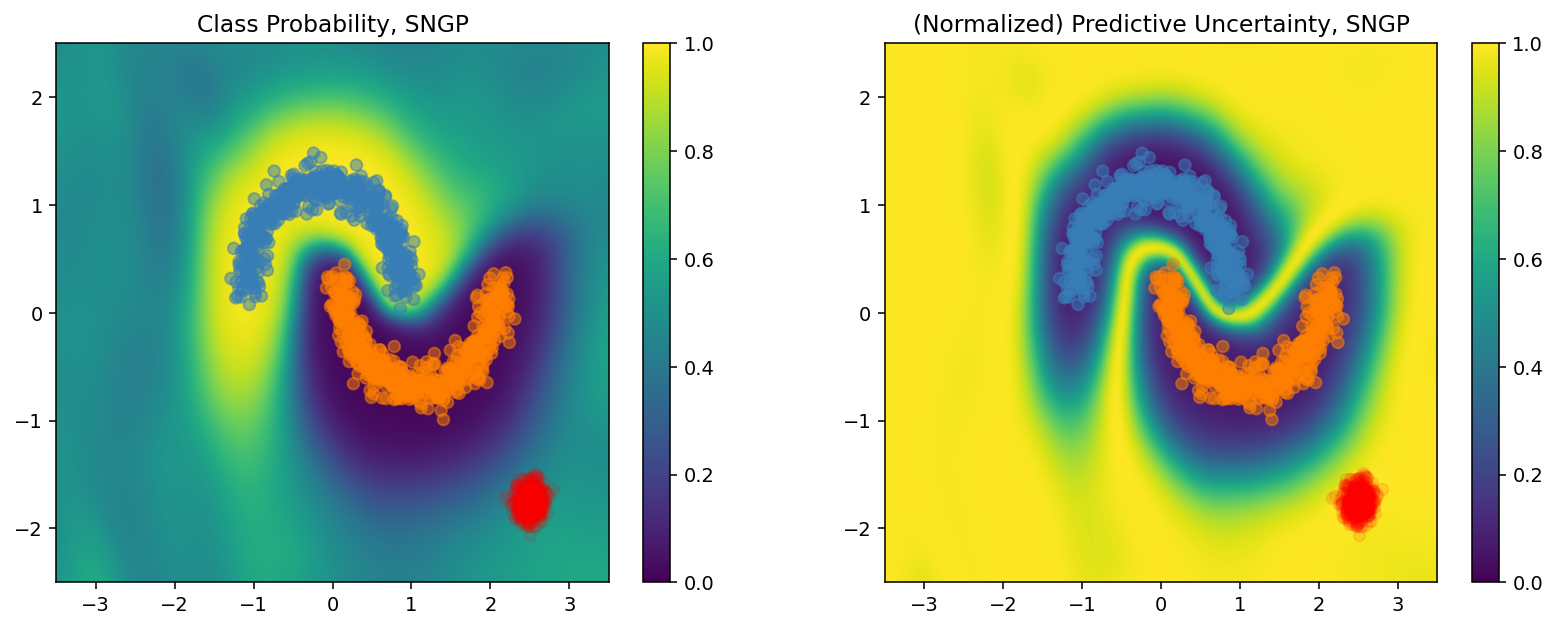

In [41]:
plot_predictions(sngp_probs, model_name="SNGP")

Remember that in the class probability plot (left), the yellow and purple are class probabilities. When close to the training data domain, SNGP correctly classifies the examples with high confidence (i.e., assigning near 0 or 1 probability). When far away from the training data, SNGP gradually becomes less confident, and its predictive probability becomes close to 0.5 while the (normalized) model uncertainty rises to 1.

Compare this to the uncertainty surface of the deterministic model: 

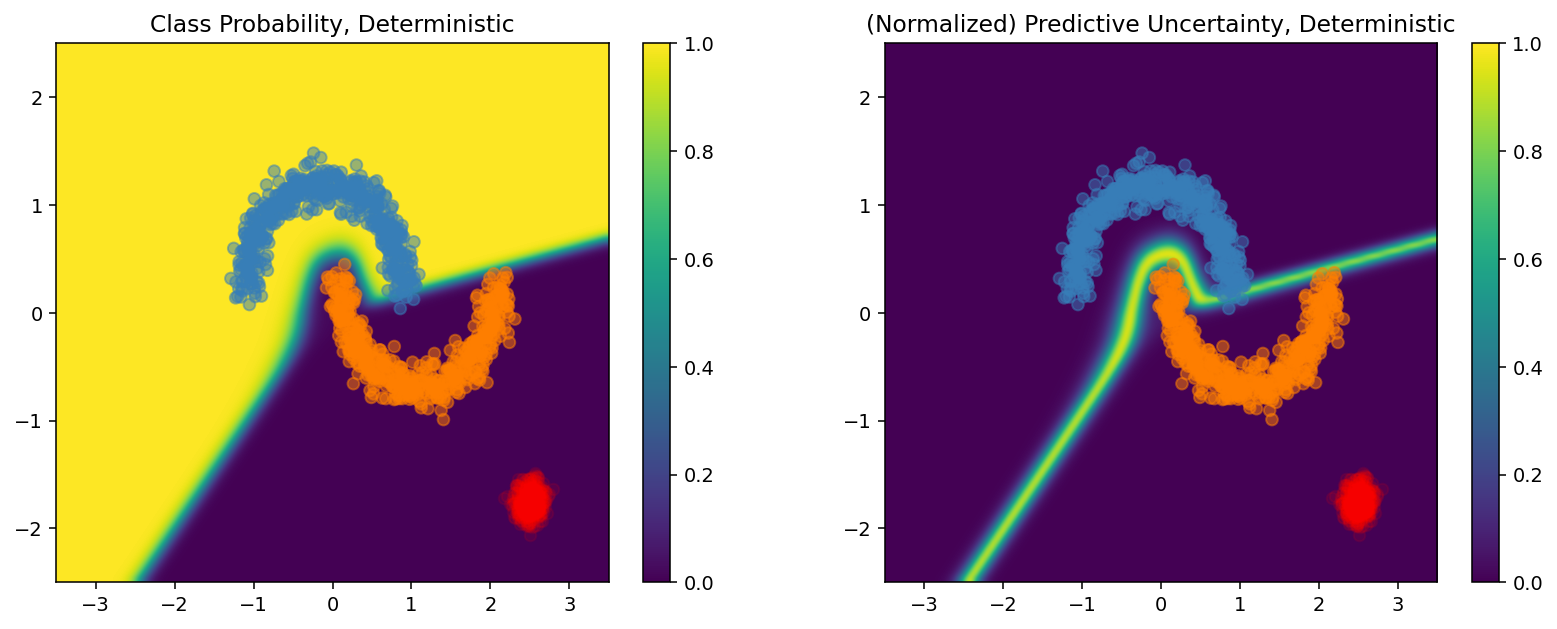

In [42]:
plot_predictions(resnet_probs, model_name="Deterministic")

As mentioned earlier, a deterministic model is not _distance-aware_. Its uncertainty is defined by the distance of the test example from the decision boundary. This leads the model to produce overconfident predictions for the out-of-domain examples (red).

## Comparison with other uncertainty approaches

This section compares the uncertainty of SNGP with [Monte Carlo dropout](https://arxiv.org/abs/1506.02142){.external} and [Deep ensemble](https://arxiv.org/abs/1612.01474){.external}.

Both of these methods are based on Monte Carlo averaging of multiple forward passes of deterministic models. First, set the ensemble size $M$.

In [43]:
num_ensemble = 10

### Monte Carlo dropout

Given a trained neural network with Dropout layers, Monte Carlo dropout computes the mean predictive probability

$$E(p(x)) = \frac{1}{M}\sum_{m=1}^M softmax(logit_m(x))$$

by averaging over multiple Dropout-enabled forward passes $\{logit_m(x)\}_{m=1}^M$.

In [44]:
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  return resnet_model(test_examples, training=True)

In [45]:
# Monte Carlo dropout inference.
dropout_logit_samples = [mc_dropout_sampling(test_examples) for _ in range(num_ensemble)]
dropout_prob_samples = [tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

In [46]:
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

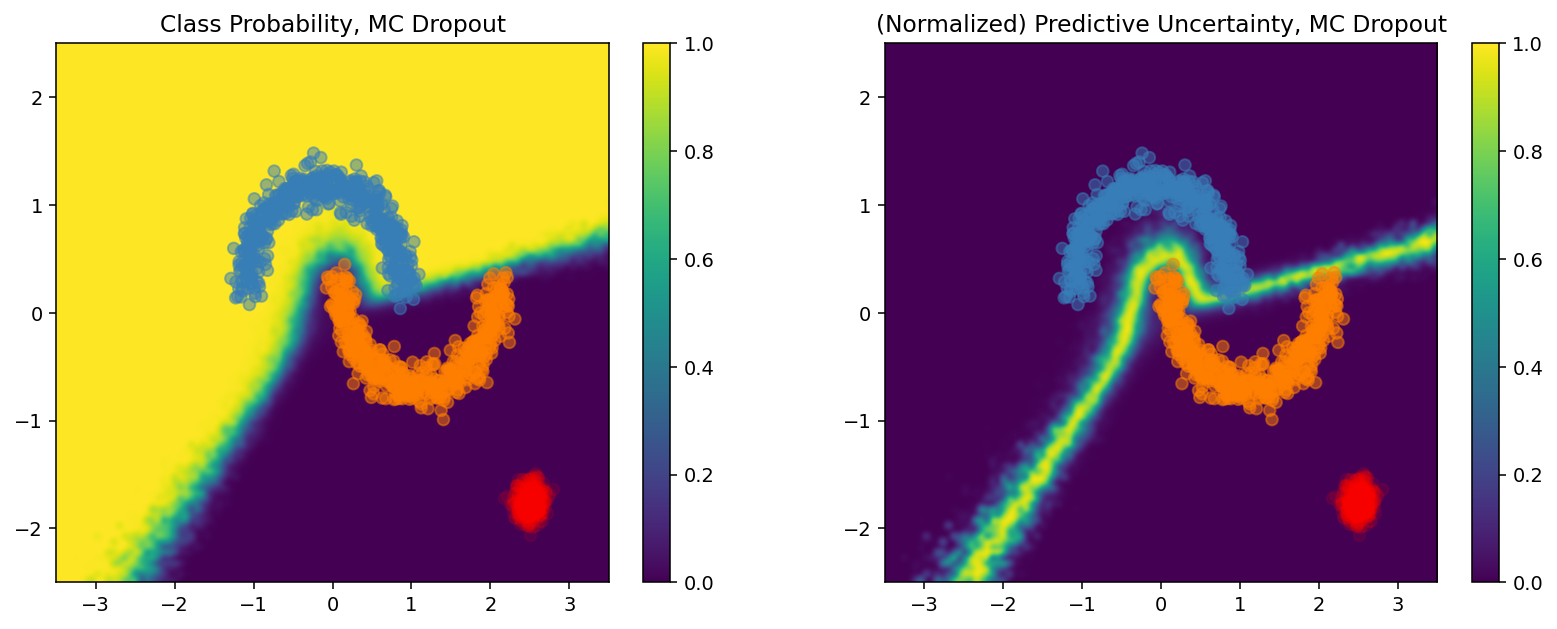

In [47]:
plot_predictions(dropout_probs, model_name="MC Dropout")

### Deep ensemble

Deep ensemble is a state-of-the-art (but expensive) method for deep learning uncertainty. To train a Deep ensemble, first train $M$ ensemble members.

In [48]:
# Deep ensemble training
resnet_ensemble = []
for _ in range(num_ensemble):
  resnet_model = DeepResNet(**resnet_config)
  resnet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  resnet_model.fit(train_examples, train_labels, verbose=0, **fit_config)

  resnet_ensemble.append(resnet_model)

Collect logits and compute the mean predictive probability $E(p(x)) = \frac{1}{M}\sum_{m=1}^M softmax(logit_m(x))$.

In [49]:
# Deep ensemble inference
ensemble_logit_samples = [model(test_examples) for model in resnet_ensemble]
ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

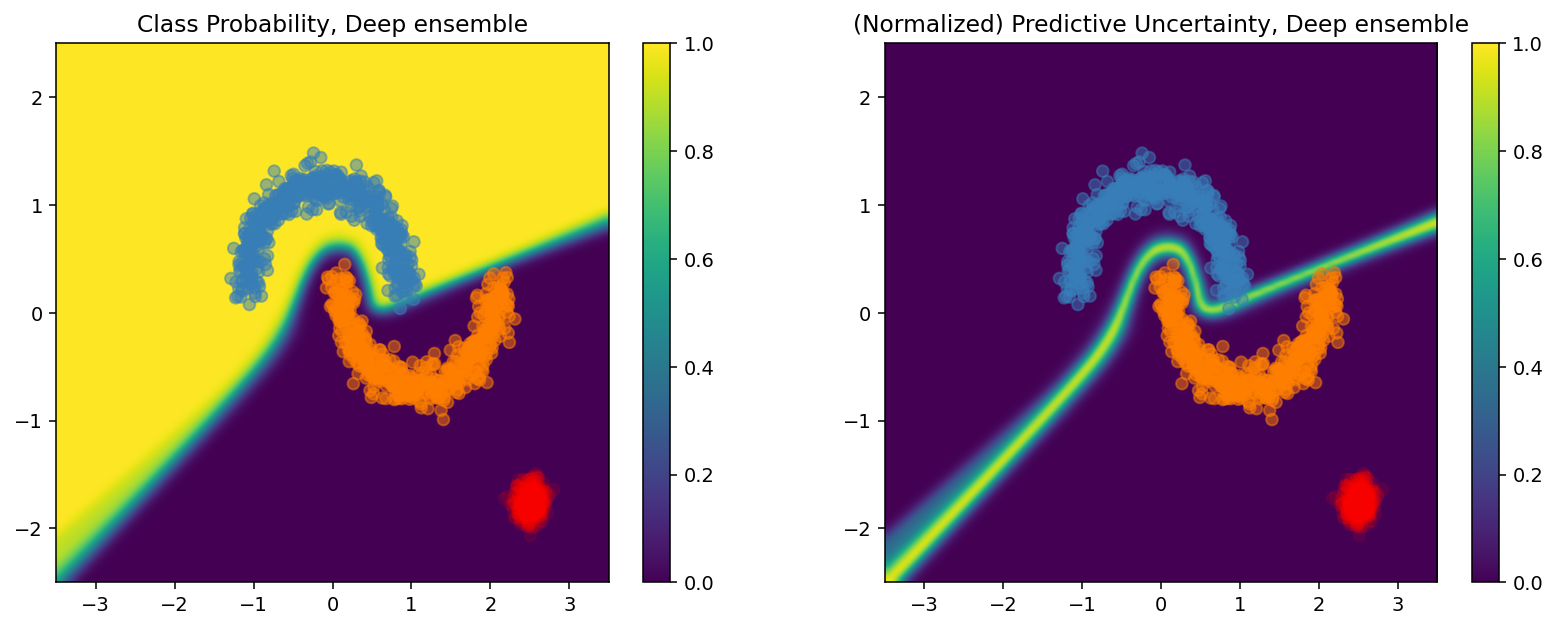

In [50]:
plot_predictions(ensemble_probs, model_name="Deep ensemble")

Both the Monte Carlo Dropout and Deep ensemble methods improve the model's uncertainty ability by making the decision boundary less certain. However, they both inherit the deterministic deep network's limitation in lacking distance awareness.

## Summary

In this tutorial, you have:
* Implemented the SNGP model on a deep classifier to improve its distance awareness.
* Trained the SNGP model end-to-end using Keras `Model.fit` API.
* Visualized the uncertainty behavior of SNGP.
* Compared the uncertainty behavior between SNGP, Monte Carlo dropout and deep ensemble models.

## Resources and further reading

* Check out the [SNGP-BERT tutorial](https://www.tensorflow.org/text/tutorials/uncertainty_quantification_with_sngp_bert) for an example of applying SNGP on a BERT model for uncertainty-aware natural language understanding.
* Go to the [Uncertainty Baselines GitHub repo](https://github.com/google/uncertainty-baselines){.external} for the implementation of SNGP model (and many other uncertainty methods) on a wide variety of benchmark datasets (for example, [CIFAR](https://www.tensorflow.org/datasets/catalog/cifar100), [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012), [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), etc).
* For a deeper understanding of the SNGP method, check out the paper titled [Simple and Principled Uncertainty Estimation with Deterministic Deep Learning via Distance Awareness](https://arxiv.org/abs/2006.10108){.external}.
